# Multi-robot Learning Over Subgoals Planning
**Multi-robot Learning over Subgoals Planning (MR-LSP)** is a planning framework that allows multiple robots to coordinate and reach a point-goal in partially-mapped environment in minimum expected distance leveraging learning. For more info, refer to the paper: [Paper](https://arxiv.org/abs/2303.16654)

In this notebook, we see how we use MR-LSP to make multiple robots reach a point goal.

In [1]:
import environments
import matplotlib.pyplot as plt
import lsp
import mrlsp

### Setting the arguments
Setting up arguments for the simulator, robot and environment

In [2]:
# Set the arguments (usually done via the command line)
args = lambda: None
args.current_seed = 2129
args.map_type = 'office2'
args.unity_path = '/unity/rail_sim.x86_64'
args.save_dir = './'
args.num_robots = 2 # the number of robots


# Robot Arguments
args.step_size = 1.8
args.num_primitives = 32
args.laser_scanner_num_points = 1024
args.field_of_view_deg = 360
args.laser_max_range_m = 18

args.inflation_radius_m = 0.75
args.base_resolution = 0.5
args.comm_range = float('inf')
args.network_file = '/data/lsp/office/training_logs/dbg/VisLSPOriented.pt'  # This is the learned model for 'office2' environment
args.disable_known_grid_correction = True

### A simulated environment
We run MR-LSP on a simulated environment. The argument `args.map_type = office2` in previous cell lets us set which environment we're running simulation in. You can choose between [`maze`, `office`, and `office2`]. In this notebook, we aim to run simulation in office2 environment.

Try changing `args.map_type` to see different maps.

NOTE: The `args.network_file` stores the path to a learned model file for `office2` environment. Therefore, in this notebook we're using `office2` environment to visualize MR-LSP planner. You could use the same learned model in `'office'` or `'maze'` environment but the performance would not be good because the newtork is trained in `'office2'` environment. However, you can simulate a non-learned *optimistic* planner in those environment to see its performance (see below on how to do that).

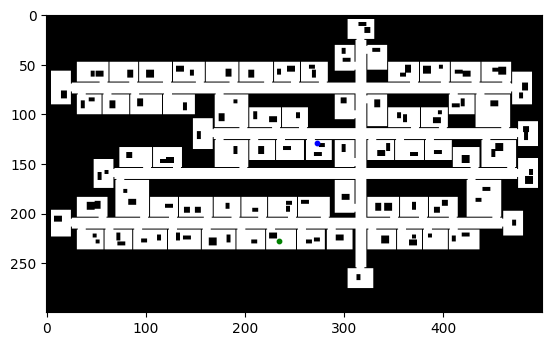

In [3]:
known_map, map_data, pose, goal = environments.generate.map_and_poses(args)

# Plotting
fig = plt.figure()
mrlsp.utils.plotting.plot_grid_with_frontiers(ax=plt.gca(),
                                              grid_map=known_map,
                                              known_map=known_map,
                                              frontiers=[])
mrlsp.utils.plotting.plot_pose(plt.gca(), pose, color='blue')
mrlsp.utils.plotting.plot_pose(plt.gca(), goal, color='green')

In the cell above, `environments.generate.map_and_poses(args)` gives the map, metadata associated with that map, the start pose, and the goal pose in the environment. We want our multiple robots to start from the start location and reach the goal location.

### Initializing robots and MR-LSP Planner
Our multiple robot team starts from the start location (`pose`) that we got from previous cell. We call `get_robot_team` function to get a list of robots that have `pose` as starting position.

#### Planner
We initialize MR-LSP planner by `mrlsp.planners.MRLearnedSubgoalPlanner(robot_team, goal_poses, args)'`. If you want to simulate a non-learned *optimistic* planner, change the line to
```python
planner = mrlsp.planners.MROptimisticPlanner(robot_team, goal_poses, args)
```

In [4]:
start_poses = [pose for _ in range(args.num_robots)]
goal_poses = [goal for _ in range(args.num_robots)]

# Get robot team
robot_team = mrlsp.utils.utility.get_robot_team(num_robots=args.num_robots,
                                                start_poses=start_poses,
                                                primitive_length=args.step_size,
                                                num_primitives=args.num_primitives,
                                                map_data=map_data)

# Initialize planner
planner = mrlsp.planners.MRLearnedSubgoalPlanner(robot_team, goal_poses, args)
# planner = mrlsp.planners.MROptimisticPlanner(robot_team, goal_poses, args)

### The visual simulator and the planning loop
Learn more about the visual simulator here: ([link](https://github.com/RAIL-group/RAIL-group-software/blob/main/resources/notebooks/RAIL-onboarding-02-visual-simulator.ipynb)). Basically, the lines below are responsible for taking the known_map occupancy grid and setting up a simulated environment using unity game engine. `Simulator` is responsible for simulating laser scan from the robot's position, getting image from robot's panoramic camera and so on.

```python
# Instantiate the simulated environment
world = environments.simulated.OccupancyGridWorld(
        known_map,
        map_data,
        num_breadcrumb_elements=args.num_breadcrumb_elements,
        min_breadcrumb_signed_distance=4.0 * args.base_resolution)

builder = environments.simulated.WorldBuildingUnityBridge
with builder(args.unity_path) as unity_bridge:
    unity_bridge.make_world(world)
    simulator = lsp.simulators.Simulator(known_map,
                                         goal,
                                         args,
                                         unity_bridge=unity_bridge,
                                         world=world,
                                         verbose=False)
    # set the inflation radius
    simulator.frontier_grouping_inflation_radius = simulator.inflation_radius
```

#### Planning Loop
The planning loop (`mrlsp.planners.MRPlanningLoop`) is responsible to make get observations from the robot and making the robot move towards the subgoal. It works in the following way:
1) Till any robot reaches the goal:
   ```python
       for counter, step_data in enumerate(planning_loop):  # 1) while loop (till any robot reaches the goal)
           # 2) take observations and give observation to the planner
           # 3) planner computes the joint-action for multi-robot team and tells planning_loop to move robots
   ```
2) The planning loop takes observation from robots sensor (lidar and panoramic camera) and gives it to the planner (MR-LSP planner)
   ```python
   planner.update({'images': step_data['images']},
                    step_data['robot_grids'],
                    step_data['subgoals'],
                    step_data['robot_poses'],
                    step_data['visibility_masks'],)
   ```
3) The planner computes the joint action for the robot team and updates the planning loop. The planning loop makes the robot move towards the action (subgoals) 
   ```python
       joint_action = planner.compute_selected_subgoal()
       planning_loop.set_chosen_subgoals(joint_action, counter)
   ```

----------------------------------------
Counter: 0
Goal: 234, 228
Robot0: (273.00, 129.00)
Robot1: (273.00, 129.00)
Total motion: 0.00


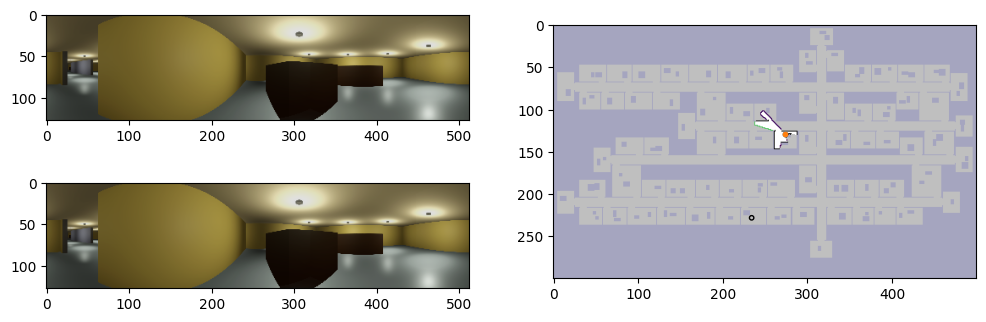

----------------------------------------
Counter: 12
Goal: 234, 228
Robot0: (258.13, 122.46)
Robot1: (266.96, 125.44)
Total motion: 21.60


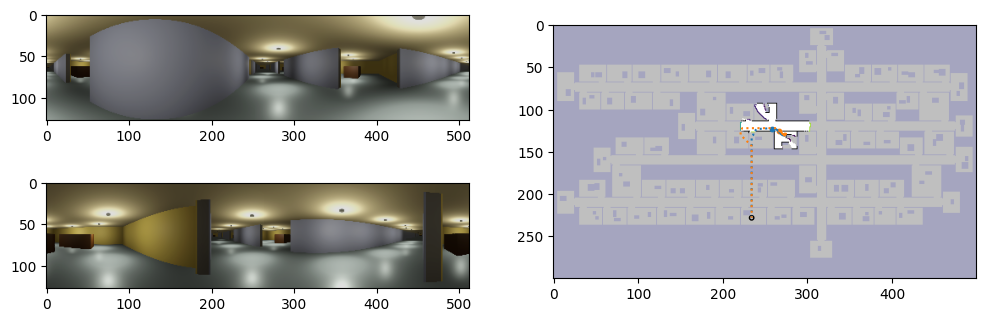

----------------------------------------
Counter: 24
Goal: 234, 228
Robot0: (236.61, 122.59)
Robot1: (285.97, 121.40)
Total motion: 43.20


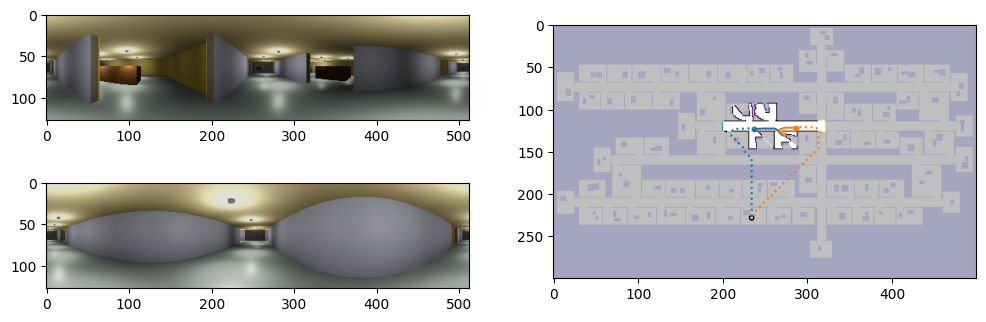

----------------------------------------
Counter: 36
Goal: 234, 228
Robot0: (225.75, 122.50)
Robot1: (307.46, 122.54)
Total motion: 64.80


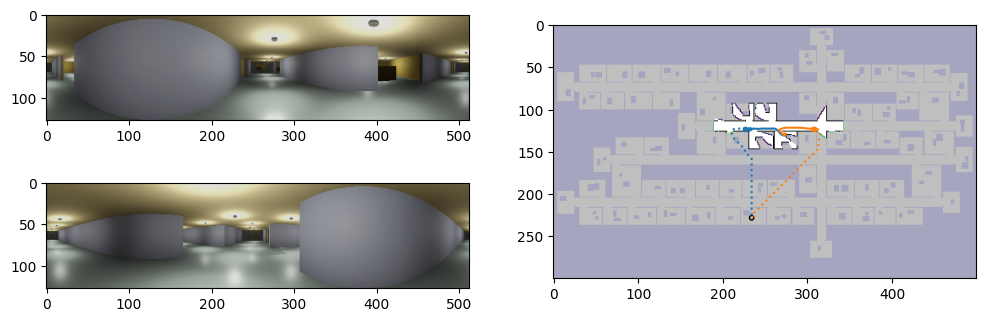

----------------------------------------
Counter: 48
Goal: 234, 228
Robot0: (206.77, 123.25)
Robot1: (315.51, 138.85)
Total motion: 86.40


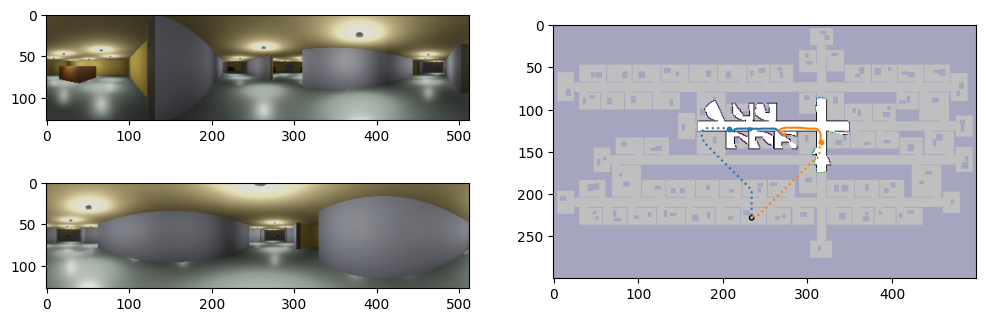

----------------------------------------
Counter: 60
Goal: 234, 228
Robot0: (212.70, 128.51)
Robot1: (313.90, 159.42)
Total motion: 108.00


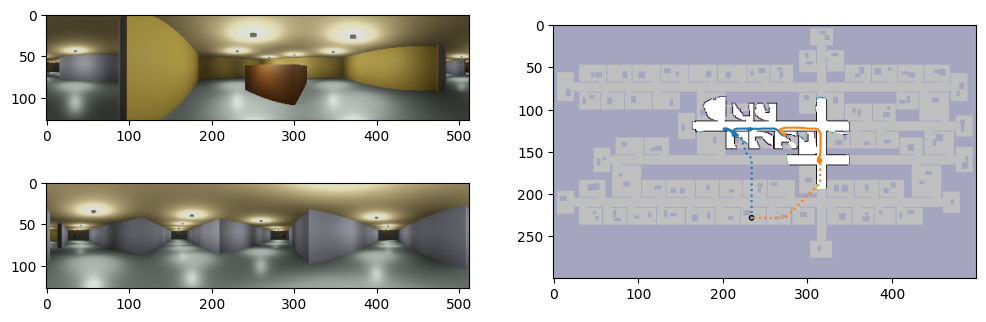

----------------------------------------
Counter: 72
Goal: 234, 228
Robot0: (211.14, 137.05)
Robot1: (315.53, 180.68)
Total motion: 131.40


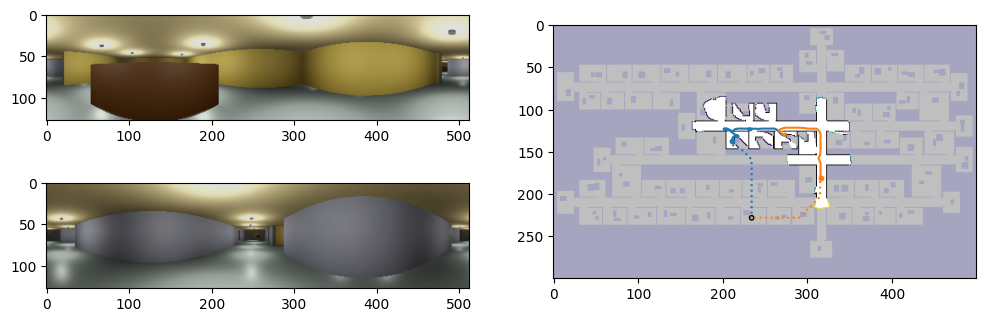

----------------------------------------
Counter: 84
Goal: 234, 228
Robot0: (203.80, 122.71)
Robot1: (315.31, 202.23)
Total motion: 153.00


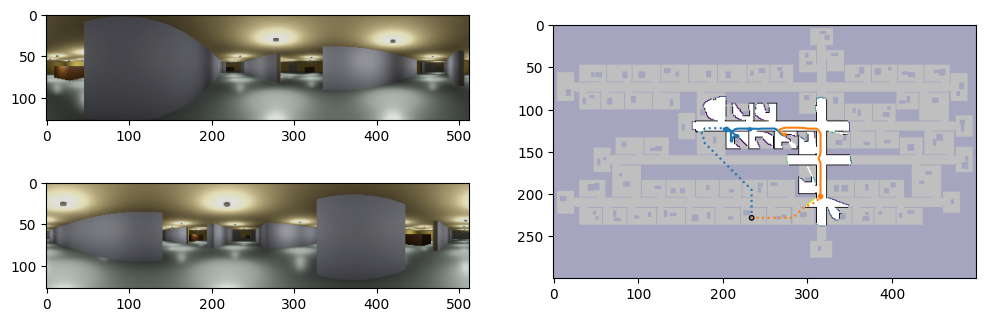

----------------------------------------
Counter: 96
Goal: 234, 228
Robot0: (191.32, 121.93)
Robot1: (297.21, 208.96)
Total motion: 174.60


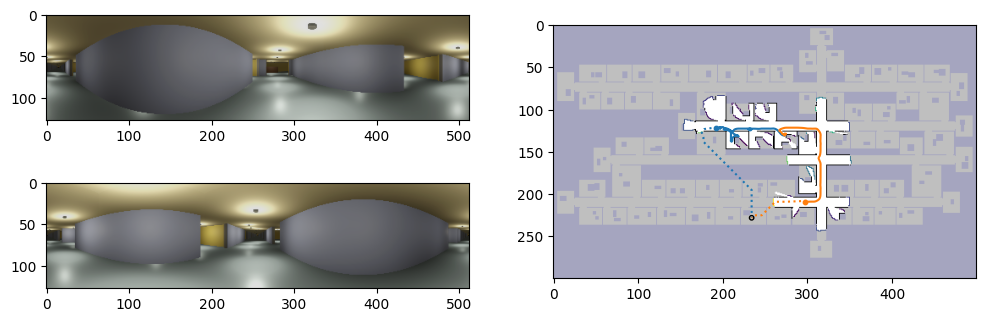

----------------------------------------
Counter: 108
Goal: 234, 228
Robot0: (191.04, 121.33)
Robot1: (275.63, 209.40)
Total motion: 196.20


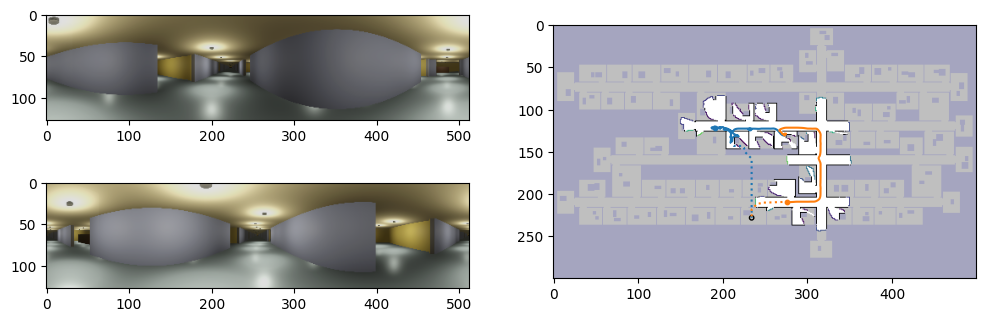

----------------------------------------
Counter: 120
Goal: 234, 228
Robot0: (187.46, 122.50)
Robot1: (254.04, 210.11)
Total motion: 217.80


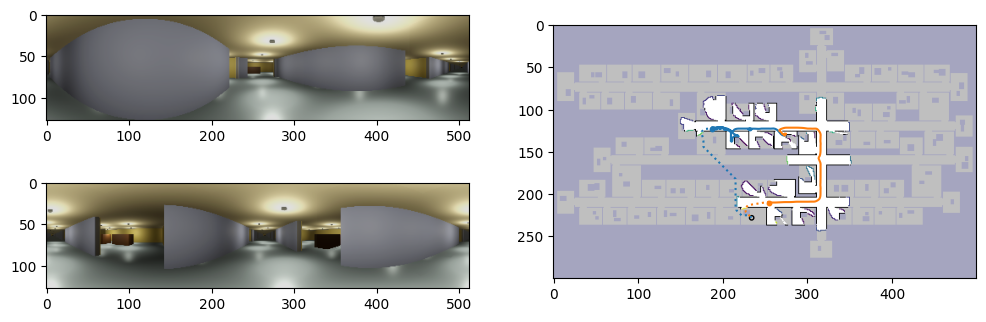

----------------------------------------
Counter: 132
Goal: 234, 228
Robot0: (184.89, 120.53)
Robot1: (232.75, 212.95)
Total motion: 239.40


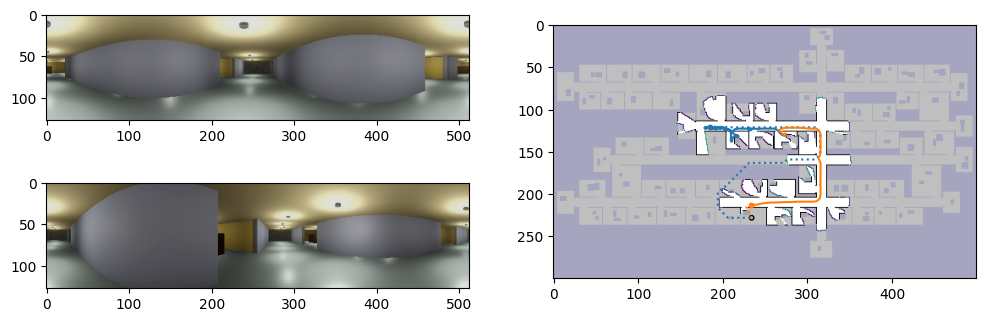

----------------------------------------
Counter: 144
Goal: 234, 228
Robot0: (195.90, 120.63)
Robot1: (223.61, 218.78)
Total motion: 261.00


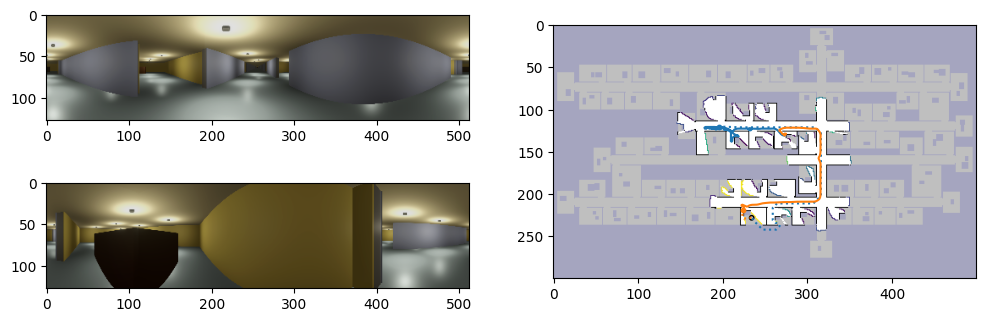

Planning loop iteration complete, [False, True]


In [5]:
# Instantiate the simulated environment
world = environments.simulated.OccupancyGridWorld(
        known_map,
        map_data,
        num_breadcrumb_elements=args.num_breadcrumb_elements,
        min_breadcrumb_signed_distance=4.0 * args.base_resolution)

builder = environments.simulated.WorldBuildingUnityBridge
with builder(args.unity_path) as unity_bridge:
    unity_bridge.make_world(world)
    simulator = lsp.simulators.Simulator(known_map,
                                         goal,
                                         args,
                                         unity_bridge=unity_bridge,
                                         world=world,
                                         verbose=False)
    # set the inflation radius
    simulator.frontier_grouping_inflation_radius = simulator.inflation_radius

    
    planning_loop = mrlsp.planners.MRPlanningLoop(goal_poses,
                                                  known_map,
                                                  simulator,
                                                  unity_bridge=None,
                                                  robots=robot_team,
                                                  args=args,
                                                  verbose=False)
    for counter, step_data in enumerate(planning_loop):
        planner.update({'images': step_data['images']},
                        step_data['robot_grids'],
                        step_data['subgoals'],
                        step_data['robot_poses'],
                        step_data['visibility_masks'],)
        joint_action = planner.compute_selected_subgoal()
        planning_loop.set_chosen_subgoals(joint_action, counter)

        # Print and plot in every 12 steps
        if counter % 12 == 0:
            # printing
            print('----------------------------------------')
            print(f'Counter: {counter}')
            print(f'Goal: {goal.x}, {goal.y}')
            for i, robot in enumerate(robot_team):
                print(f'Robot{i}: ({robot.pose.x:.2f}, {robot.pose.y:.2f})')
            print(f'Total motion: {robot_team[0].net_motion:.2f}')

            # plotting
            plt.ion()
            plt.figure(1, figsize=(12, 4))
            plt.clf()
            mrlsp.utils.plotting.visualize_robots(args=args,
                                                  robots=robot_team,
                                                  observed_map=planner.observed_map,
                                                  pano_images=step_data['images'],
                                                  subgoals=planner.subgoals,
                                                  goal_pose=goal,
                                                  paths=planning_loop.paths,
                                                  known_map=known_map,
                                                  timestamp=counter)
            plt.show()